In this notebook we will implement the calculation of **CONSTANT HEIGHT STM IMAGES**.


The equations
--------------

Using the Tersoff-Hammann aproximation (https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.50.1998), **the tunneling current is proportional to the local density of states** at a certain point close to the material:

$$
I(\vec{r}, V) \propto \int_0^V LDOS(\vec{r}, E_f - V + \epsilon) \,d\epsilon\
$$

The LDOS at a certain energy is simply described as the electron density, computed as $\psi(\vec{r}) \psi^*(\vec{r})$, considering only  wavefunctions at that energy:

$$
LDOS(r, E) = \sum_{i} n(E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})  
$$

Where $n(E, \epsilon)$ is the occupation function that determines the contribution of a given wavefunction. $E$ is the energy for which we want the LDOS and $\epsilon_i$ is the energy of the wavefunction. One possible occupation function is Dirac's delta:

$$
n(E, \epsilon) = \delta(E - \epsilon) = 
\begin{cases}
  1, & \text{if}\ E = \epsilon \\
  0, & \text{otherwise}\
\end{cases}\,.
$$

In summary, to compute constant height STM images. We need to:
- Get a Hamiltonian (we will use SIESTA for this).
- Compute the eigenstates (wavefunction coefficients) and eigenvalues (energies).
- Implement a function that computes the STM current $I(\vec{r}, V)$ for any point in space $\vec{r}$ at a given voltage $V$. The full equation is:

$$
I(\vec{r}, V) \propto \int_0^V \sum_{i} \left[n(-V + E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})\right] \,dE\
$$

- Take the points of space of a given plane (at constant height), as an STM tip would do.

In this first case, we will **compute STM images of a benzene molecule**.

Tips
------

**To build the molecule:**

You can use the `ase` (Atomic Simulation Environment) python package. It has a function `ase.build.molecule` that can generate a benzene molecule. Look at its documentation (https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.molecule) to understand how to use it. Add at least 5 Ang of vacuum!

**To write the molecule to a file:**

`ase` will give you an `ase.Atoms` object. You can convert it to `sisl` with `sisl.Geometry.new(ase_atoms)`. Then you can write it to an fdf file as usual.

Plot the molecule before writing it to make sure that it is what you expect.

**To run the SIESTA calculation:**

You will need the Hamiltonian, so don't forget to tell siesta to store it in a `.TSHS` file by using `TS.HS.Save true`.

**To read the Hamiltonian:**

Once the SIESTA run has finished, you can do:

```python
sisl.get_sile("path/to/my/file.fdf").read_hamiltonian()
```

as we have done in previous lab sessions.

**To compute wavefunctions on the grid:**

To compute $\psi (\vec{r})$ you need three things.

1. **The eigenstate coefficients.** Once you have a hamiltonian, you can get all of them with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. Each eigenstate has its energy stored under the `.eig` property.
2. **A grid of points in space.** You can create one with `sisl.Grid((100, 100, 100), geometry=geometry)`. This will create a grid of $100x100x100$ points within the cell of your geometry.
3. **A function to project the wavefunction into the grid.** The eigenstate object has a `wavefunction` method ([docs](https://zerothi.github.io/sisl/api/generated/sisl.physics.electron.EigenstateElectron.html#sisl.physics.electron.EigenstateElectron.wavefunction)) that will project the wavefunction into an already initialized grid.

Remember that we have done this already on the first SIESTA lab, with a water molecule.

**To plot the STM images at a certain height:**

A function is provided to plot molecules at multiple heights. You can use it as it is or modify it as you wish.

*Note*: If you have time, you can modify this function to create a plots at multiple voltages. Even a grid of plots at multiple voltages and multiple heights!

**To check that things make sense:**

You can plot all the eigenstates of your system to try to understand if the STM images make sense with something like:

```python
H.plot.pdos(data_Erange=[-10, 10], nE=1200, Erange=[-10, 10], kgrid=[1,1,1]).split_DOS(on="species+l+m")
```

Helper: Grids have a `fill` method to set all the values of the grid to a given value, if that is needed.

Let's get to work
---------------

From now on, you have to implement the STM images! 

Look at the equation for current and try to think how that can be translated into code. If you get stuck, experiment with whatever ideas you have! There's no harm in making python error, you won't break it ;)

**Some imports:**

In [6]:
import sisl
import sisl.viz
import numpy as np

**The helper function to plot STM images once you have the LDOS grid:**

In [7]:
# The helper function
def plot_STM_images(
    LDOS_grid: sisl.Grid, 
    min_height: int = 0, 
    max_height: int = 2,
    steps: int = 9,
    crange = None,
    colorscale: str = None
):
    """Plots constant height STM images at multiple heights

    Parameters
    ----------
    LDOS_grid:
        A grid containing the LDOS corresponding to the voltage that you
        want to plot, for ALL SPACE.
    min_height:
        The height of the first image.
    max_height:
        The height of the last image.
    steps:
        The number of steps between the first and the last image.
    log:
        Whether to plot the log of the values.
    crange:
        The range of the colorscale. E.g. [0, 2]. If None, it is computed
        from the minimum and maximum values of the data.
    colorscale:
atoms = molecule('H2O')
        The plotly colorscale to use.

    Examples
    ----------

    This function should be used like:
    >>> grid = ...compute the LDOS in the grid.
    >>> plot_STM_images(grid)
    """

    # Determine all the heights that the user wants to plot
    heights = np.linspace(min_height, max_height, steps)
    # Get the position of the benzene molecule
    z_0 = grid.geometry.xyz[:, 2].max()
    
    # Initialize a list of plots
    plots = []
    coloraxes = []
    # Loop through the heights, and for each of them we will create a plot.
    for height in heights:
        # Get the z for which we want the LDOS (benzene position + height)
        z = z_0 + height
        
        # Get the plot for this height
        plot = LDOS_grid.plot(axes="xy", z_range=[z - 0.1, z + 0.1], crange=crange, colorscale=colorscale)

        # And append it to the list
        plots.append(plot)

    # Merge all the plots, with some extra arguments to beautify the plot.
    return sisl.viz.merge_plots(
        *plots, 
        composite_method="subplots", 
        arrange="square", 
        subplot_titles=[f"Height = {height} Ang" for height in heights],
        horizontal_spacing=0,
        vertical_spacing=0.05
    ).update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=900, title=f"Constant height STM images",
    )

**A function skeleton:**

Thinking of things as a function helps you understand what you expect to get as an input and what you are expected to produce as an output. Here is a skeleton that might help you with your implementation:

In [8]:
def LDOS_grid(H, V):
    """Computes the LDOS in a grid.

    Parameters
    ----------
    H:
        the Hamiltonian of the system
    V:
        the voltage for which you want the LDOS.
    """

    grid = #...compute grid

    return grid

SyntaxError: invalid syntax (3660427839.py, line 12)

This function contains the basic arguments, of course you could add more inputs to allow the user to further tweak the functionality.

**Your place to work:**

Treball previ
----------

Construïm una molècula de benzé:

In [70]:
from ase.collections import g2
print(g2.names)

['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '2-butyne', 'C2H5', 'BF3'

In [71]:
from ase.build import molecule
benzene = molecule('C6H6', vacuum=5)

In [72]:
benzene

Atoms(symbols='C6H6', pbc=False, cell=[14.299574, 14.96472, 10.0])

Escribim la molècula en un fitxer i la representem:

In [73]:
geometry = sisl.Geometry.new(benzene)

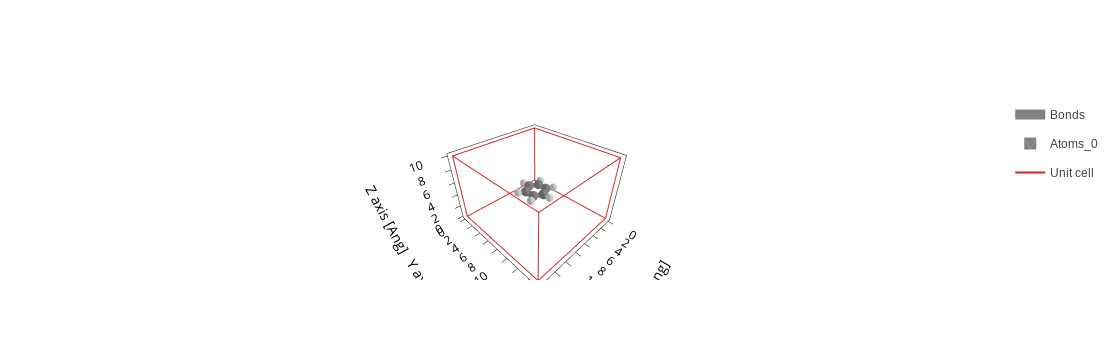

In [74]:
geometry.plot()

In [14]:
geometry.write('benzene.fdf')

Afegim "TS.HS.Save true" al fitxer .fdf i l'executem amb SIESTA per generar el Hamiltonià del benzè:

In [75]:
hamiltonian = sisl.get_sile("benzene.fdf").read_hamiltonian()
hamiltonian

<sisl.physics.Hamiltonian na=12, no=108, nsc=[1 1 1], dim=2, nnz=11658, spin=unpolarized>

Calculem els valors i vectors propis del sistema:

In [76]:
eigenstate = hamiltonian.eigenstate()
print("Els valors propis són:")
eigenstate.eig

Els valors propis són:


array([-16.85584921, -14.0856129 , -14.08561174, -10.53069213,
       -10.53054227,  -8.65691373,  -6.88636117,  -6.66710033,
        -5.94719358,  -5.94660128,  -4.7629345 ,  -3.947479  ,
        -3.9472216 ,  -2.0336825 ,  -2.0335716 ,   3.17039698,
         3.17043392,   6.11502598,   7.11138195,   7.63003778,
         7.63105022,   8.40580666,   8.40584601,   9.16184149,
        11.24458368,  11.24516225,  11.43573032,  11.43615096,
        11.82269438,  12.22032039,  12.44676789,  14.53391452,
        14.534041  ,  15.05254152,  15.05304262,  15.49873408,
        16.05283721,  16.05462092,  16.98877124,  17.24325958,
        17.47766281,  17.47772598,  18.04618741,  19.26995222,
        19.89849062,  21.96329687,  21.96476612,  22.06533538,
        22.06778255,  22.08878172,  22.08900384,  23.82259741,
        23.82262539,  24.69043576,  24.9404016 ,  24.94327857,
        25.9243249 ,  26.8633256 ,  26.8666338 ,  27.21287037,
        27.50885201,  28.22176221,  28.22599683,  29.59

In [77]:
print("La matriu de coeficients dels vectors propis és:")
eigenstate.state

La matriu de coeficients dels vectors propis és:


array([[-1.09925713e-01, -1.19827740e-01, -7.05316328e-02, ...,
        -9.40630466e-03,  4.52347454e-14,  1.62604286e-02],
       [-1.05468443e-01, -2.07729764e-01, -3.65206681e-02, ...,
        -1.32996208e-03,  4.59602246e-14,  1.68417616e-02],
       [ 8.12859825e-06,  1.60103299e-05,  2.81518425e-06, ...,
         1.69382054e-02, -7.79484619e-14, -2.09514135e-02],
       ...,
       [-1.01930569e+01,  5.65075698e+00, -5.30174661e+00, ...,
        -4.42861412e-01, -1.80700029e-11,  7.66495053e-01],
       [ 3.68230551e+00, -1.60928037e+00,  8.60129318e-01, ...,
        -1.43037395e-01,  3.46062363e-12,  2.47810531e-01],
       [-4.56808623e-07,  3.58166820e-07, -1.09764247e-08, ...,
         8.01078190e-01,  8.34977094e-15,  4.62464331e-01]])

Definim un grid de dimensions 100x100x100 i el representem en el pla xy:

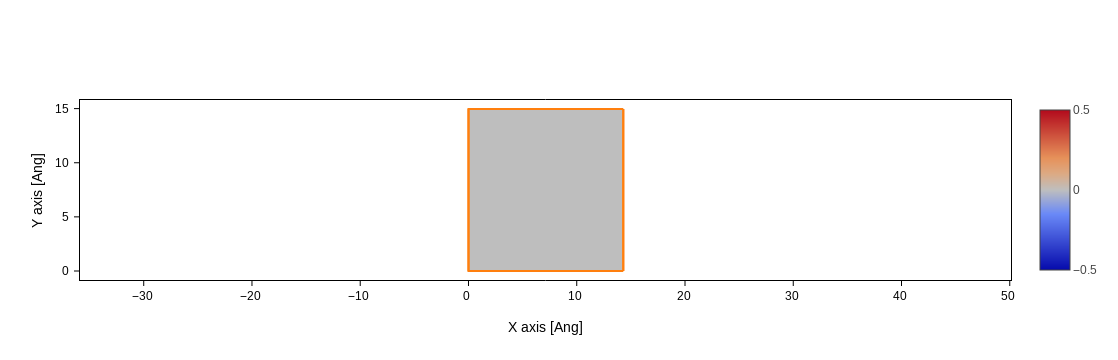

In [20]:
grid=sisl.Grid((100,100,100), geometry=geometry)
grid.plot(axes="xy")

Representem un grid 100x100x100 dels estats propis de la 1a funció d'ona:

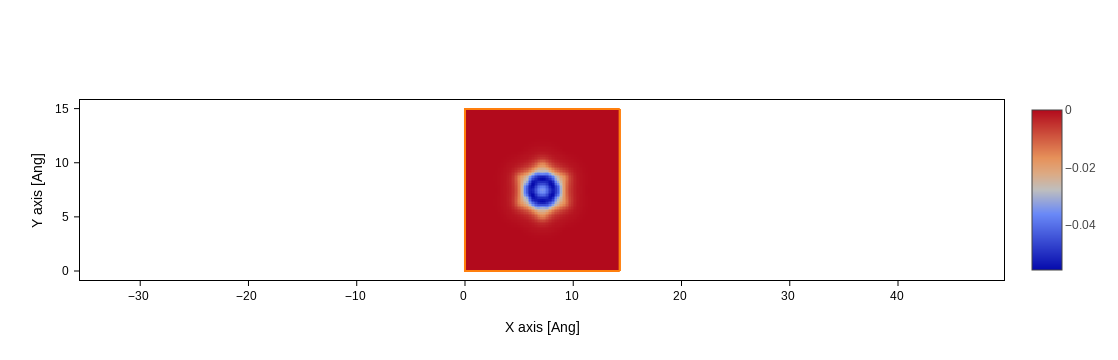

In [78]:
grid.fill(0)
eigenstate[0].wavefunction(grid)
grid.plot(axes='xy')

**LDOS del primer estat propi**

Calculem la matriu de coeficients pel primer estat propi:

In [82]:
eigenstate.state[0]

array([-1.09925713e-01, -1.19827740e-01, -7.05316328e-02,  1.74169437e-13,
        6.00793447e-10, -1.72112596e-02, -4.87539655e-13, -5.41782737e-10,
       -7.05169186e-11,  3.63048290e-14,  2.35167625e-03, -1.74942700e-16,
       -3.15113221e-03, -1.10474195e-01, -1.19486586e-01, -3.54451898e-02,
        1.67187488e-13, -6.13195814e-02, -8.46413203e-03, -4.82890932e-13,
       -1.47240589e-02,  2.66831557e-03,  1.77601869e-14,  2.37315443e-03,
        3.13201960e-14,  1.55625946e-03, -1.10474195e-01, -1.19486585e-01,
        3.54451863e-02,  1.76124831e-13, -6.13195837e-02,  8.46413473e-03,
       -4.89240830e-13, -1.47240570e-02, -2.66831448e-03, -1.84435296e-14,
        2.37315443e-03,  3.12892566e-14,  1.55625976e-03, -1.09925713e-01,
       -1.19827740e-01,  7.05316320e-02,  1.72353298e-13, -2.40388942e-09,
        1.72112603e-02, -4.86682586e-13,  1.96070041e-09, -8.18679462e-10,
       -3.60768752e-14,  2.35167630e-03,  2.91433132e-16, -3.15113240e-03,
       -1.10474194e-01, -

Representem els LDOS pel primer estat propi (per calcular el LDOS multipliquem la funció d'ona del primer estat pel seu conjugat). En el cas del benzè, les funcions d'ona no tenen component imaginari pel que el conjugat de la funció és ella mateixa.

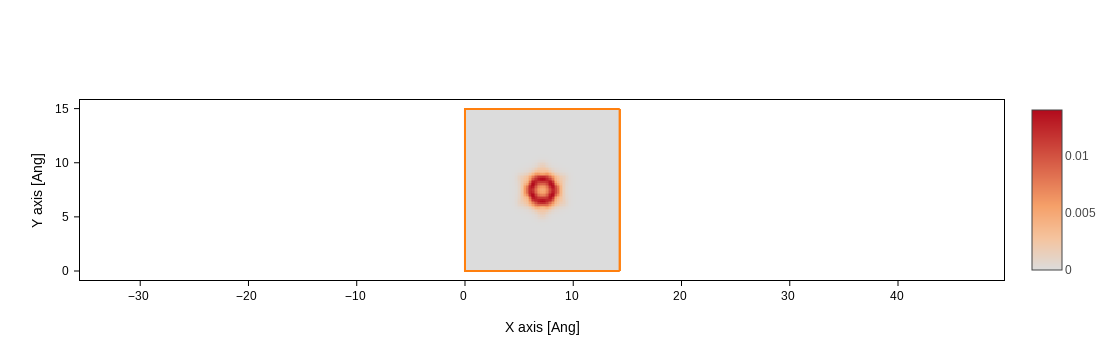

In [87]:
grid1=sisl.Grid((100,100,100), geometry=geometry)
eigenstate[0].wavefunction(grid1)
G1_LDOS = grid1*grid1 
G1_LDOS.plot(axes='xy')

**LDOS total de la molècula de benzé**

Calculem la LDOS total del benzé. Per fer-ho seguïm la següent estratègia:
- Creem un grid "G" inicialment buit.
- Creem un grid temporal "grid_t" que anirà variant.
- Definim un bucle on calculem la LDOS per cada funció d'ona (que ho gaurdem en el grid "grid_t") i ho anem sumant al grid "G" (dins de cada esta del bucle, el grid "G" conté la infromació de la LDOS per tots aquells estats < n. 
- Representem el grid "G", que contindrà la informació de la LDOS de tot el sistema.

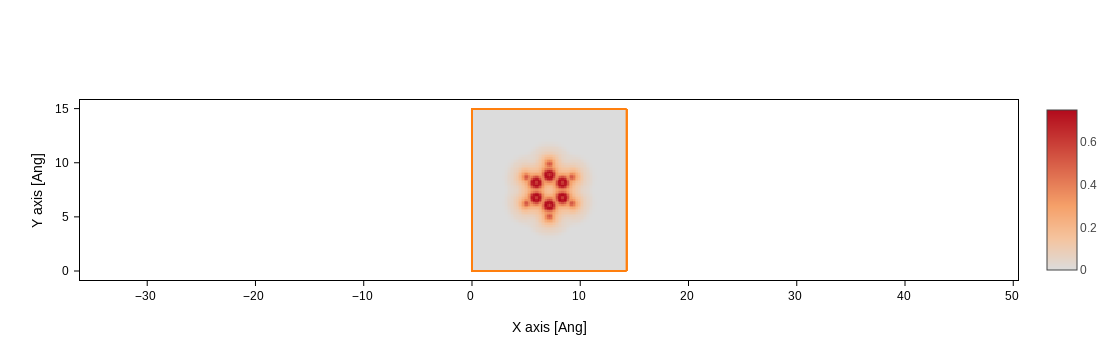

In [90]:
G = sisl.Grid((100,100,100), geometry=geometry)      # definim un grid buit que anomenem G
grid_t = sisl.Grid((100,100,100), geometry=geometry) # definim un grid buit que anomenem grid_t 

for n in range(0,108):                               # definim un bucle que s'executi per les 108 funcions d'ona que tenim pel cas del benzè
    grid_t.fill(0)                                   # buidem tota la informaciò previament guardada al grid_t
    eigenstate[n].wavefunction(grid_t)               # calculem la funció d'ona de l'estat n
    G_n = grid_t*grid_t                              # calculem la LDOS de l'estat n
    G = G + G_n                                      # sumem la LDOS de l'estat n al grid G

G.plot(axes='xy')                                    # representem la LDOS total

NOTA: El SIESTA ha utilitzat orbitals DZP per generar el Hamiltonià de l'estructura (i.e. 108 orbitals). Això fa que tinguem 108 estats propis.

Intensitat imatges STM en funció del voltatge
----

Calculem la LDOS de tots els estats que tenim en una energia entre 0 i 10 eV (i.e. la LDOS que observaríem amb un STM en aplicar una diferència de potencial de -10 V)

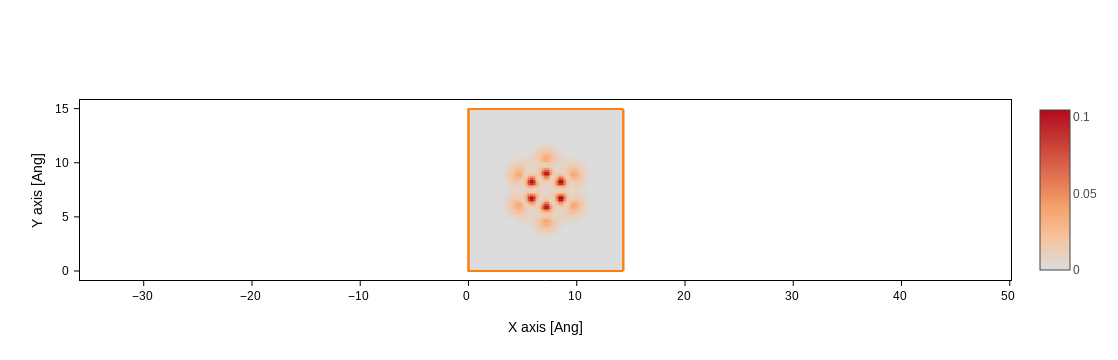

In [100]:
G.fill(0)                                   # buidem la informació que tenim guardada al grid G
V=10                                        # fixem l'energia fins on volem avaluar els LDOS (en aquets cas 10 eV).

for n in range(0,108):                      # definim un bucle que s'executi per les 108 funcions d'ona que tenim pel cas del benzè 
    
    if 0<eigenstate[n].eig<V:               # definim un condicional de mode que el que precedeuxi només s'executi per estats amb un valor propi amb energies entre 0 i V
        grid_t.fill(0)                      # buidem la informació que tenim guardada al grid_t
        eigenstate[n].wavefunction(grid_t)  # calculem la funció d'ona de l'estat n
        G_n = grid_t*grid_t                 # calculem la LDOS de l'estat n
        G = G + G_n                         # sumem la LDOS de l'estat n al grid G

G.plot(axes='xy')                           # representem la LDOS total entre energies de 0 a V

In [ ]:
Per poder representar les imatges STM per diferents voltatges definim una funció on definim la 

In [109]:
def STM_grid(V,H):
    G = sisl.Grid((100,100,100), geometry=geometry)
    G.fill(0)
    grid_t = sisl.Grid((100,100,100), geometry=geometry)
    eigenstate = H.eigenstate()
  
    for n in range(0,108):
            
        if 0<eigenstate[n].eig<V:
            grid_t.fill(0)
            eigenstate[n].wavefunction(grid_t)
            G_n = grid_t*grid_t
            G = G + G_n
        
    return G

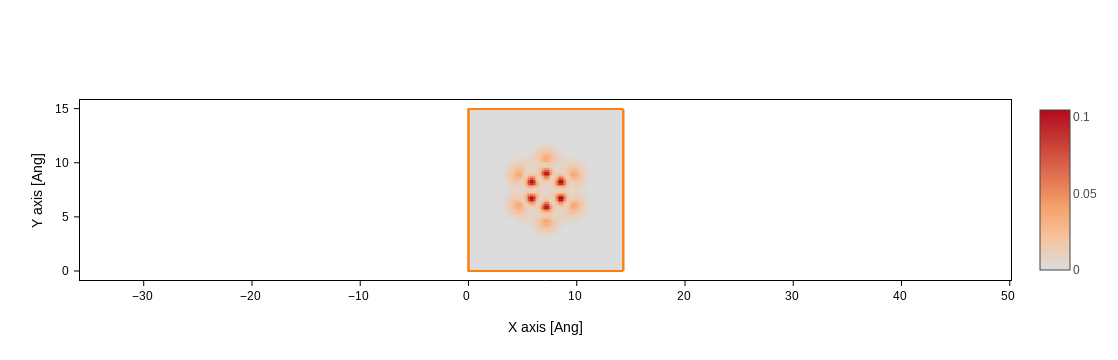

In [111]:
STM_grid(10,hamiltonian).plot(axes='xy')

PDOS
----

Representem la PDOS del benzè (per un rang de -10 eV a 10 eV):

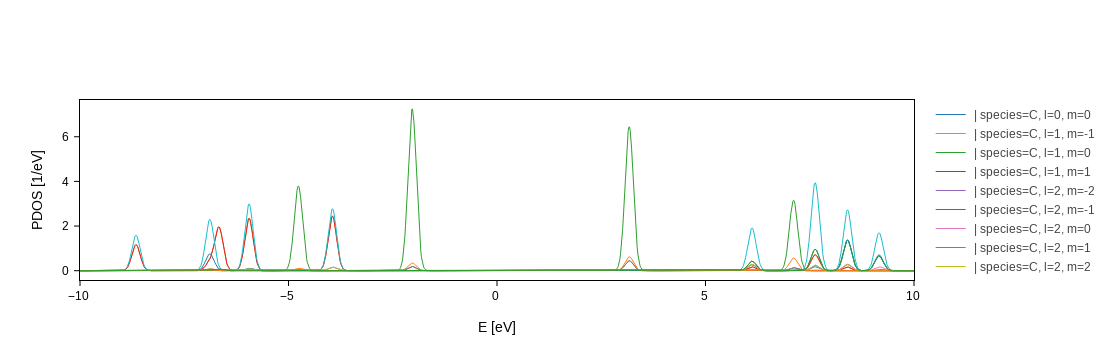

In [106]:
hamiltonian.plot.pdos(data_Erange=[-10, 10], nE=1200, Erange=[-10, 10], kgrid=[1,1,1]).split_DOS(on="species+l+m")

Imatges STM
--------

Calculem imatges de STM a diferents altures (de 0 a 2 Ansgstroms) per la LDOS corresponent als estats amb energies entre 0 i 10 eV.
Per fer-ho, afegim al codi anterior el "helper function to plot STM images" que trobem a l'inici de la notebook:

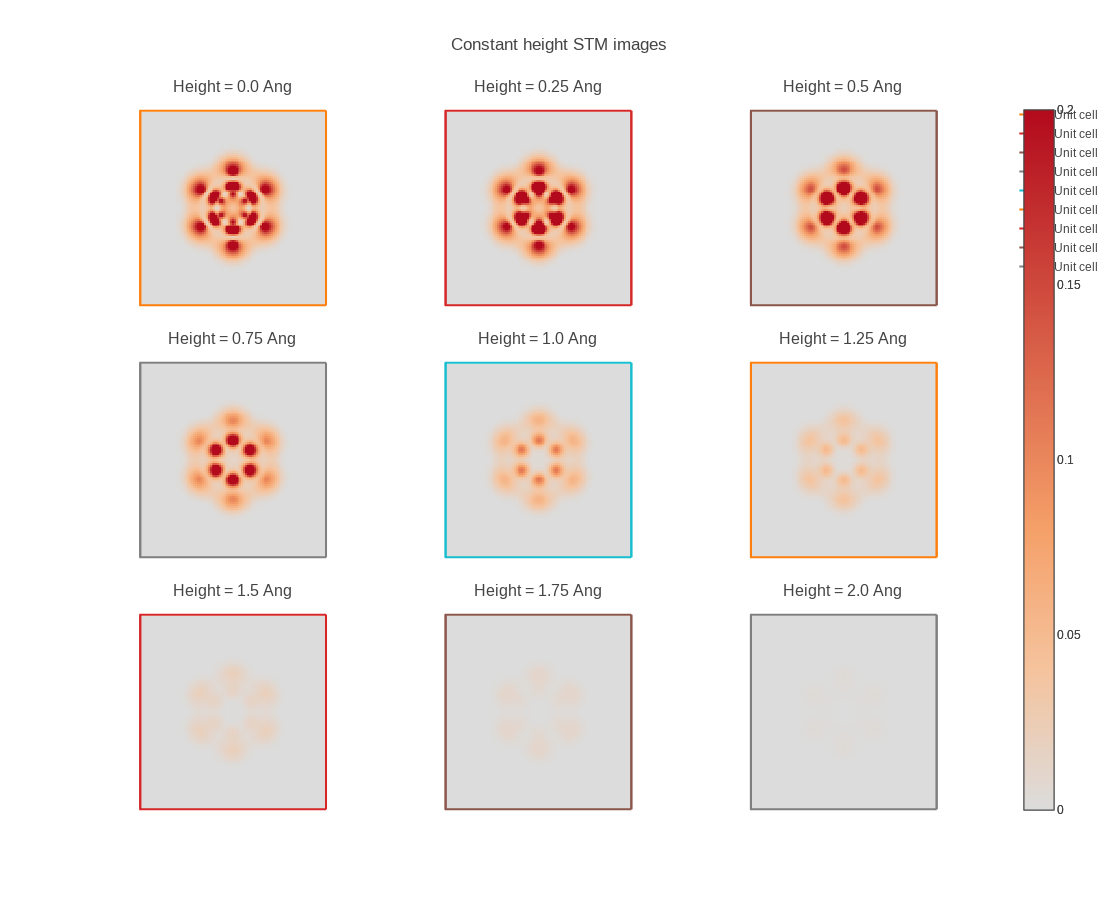

In [108]:
G.fill(0)                                   # buidem la informació que tenim guardada al grid G
V=10                                        # fixem l'energia fins on volem avaluar els LDOS (en aquets cas 10 eV).

for n in range(0,108):                      # definim un bucle que s'executi per les 108 funcions d'ona que tenim pel cas del benzè 
    
    if 0<eigenstate[n].eig<V:               # definim un condicional de mode que el que precedeuxi només s'executi per estats amb un valor propi amb energies entre 0 i V
        grid_t.fill(0)                      # buidem la informació que tenim guardada al grid_t
        eigenstate[n].wavefunction(grid_t)  # calculem la funció d'ona de l'estat n
        G_n = grid_t*grid_t                 # calculem la LDOS de l'estat n
        G = G + G_n                         # sumem la LDOS de l'estat n al grid G

# The helper function
def plot_STM_images(
    LDOS_grid: sisl.Grid, 
    min_height: int = 0,                    # fixem l'alçada mínima a 0 angstroms (i.e. la punta està en contacte amb la mostra)
    max_height: int = 2,                    # fixem l'alçada màxima a 2 angstroms (i.e. la punta està a 2 angroms de la mostra)
    steps: int = 9,                         # augmentem l'alçada de 0 a 2 angstroms en 9 intervals
    crange = None,
    colorscale: str = None
):
    """Plots constant height STM images at multiple heights

    Parameters
    ----------
    LDOS_grid:
        A grid containing the LDOS corresponding to the voltage that you
        want to plot, for ALL SPACE.
    min_height:
        The height of the first image.
    max_height:
        The height of the last image.
    steps:
        The number of steps between the first and the last image.
    log:
        Whether to plot the log of the values.
    crange:
        The range of the colorscale. E.g. [0, 2]. If None, it is computed
        from the minimum and maximum values of the data.
    colorscale:
        The plotly colorscale to use.

    Examples
    ----------

    This function should be used like:
    >>> grid = ...compute the LDOS in the grid.
    >>> plot_STM_images(grid)
    """

    # Determine all the heights that the user wants to plot
    heights = np.linspace(min_height, max_height, steps)
    # Get the position of the benzene molecule
    z_0 = G.geometry.xyz[:, 2].max()
    
    # Initialize a list of plots
    plots = []
    coloraxes = []
    # Loop through the heights, and for each of them we will create a plot.
    for height in heights:
        # Get the z for which we want the LDOS (benzene position + height)
        z = z_0 + height
        
        # Get the plot for this height
        plot = LDOS_grid.plot(axes="xy", z_range=[z - 0.1, z + 0.1], crange=crange, colorscale=colorscale)

        # And append it to the list
        plots.append(plot)

    # Merge all the plots, with some extra arguments to beautify the plot.
    return sisl.viz.merge_plots(
        *plots, 
        composite_method="subplots", 
        arrange="square", 
        subplot_titles=[f"Height = {height} Ang" for height in heights],
        horizontal_spacing=0,
        vertical_spacing=0.05
    ).update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=900, title=f"Constant height STM images",
    )

plot_STM_images(G, crange=[0, 0.2])      # fixem el màxim rang de crange a 0.2 ja que per un valor més gran no s'observa la LDOS per una altura de 2 Angstom

In [ ]:
-1 y, 0 z, 1 x